# Ship Classification

In [120]:
import os
import random
import numpy as np
import pandas as pd
import cv2
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    History
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.TPUStrategy(tpu)
#     print("Using strategy:", strategy)
# except ValueError:
#     print('TPU not found. Using default strategy.')
#     strategy = tf.distribute.get_strategy()

strategy = tf.distribute.get_strategy()

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


# Problem Description

In this notebook I'll be working on the Game of Deep Learning: Ship Classification dataset from Kaggle to classify images of ships into either Cargo, Military, Carrier, Cruise, or Tanker ships. The type of ship is represented by an integer 1 through 5 for each respective category.

Both the train and test datasets have a decent amount of data and there are 6252 images in the training set and 2680 images in the test set.

# Loading the Data

Since the training data has a category column of integers, let's create a map so that we can reference what kind of ship we are looking at later on.

In [121]:
ships = {1: 'Cargo',
         2: 'Military',
         3: 'Carrier',
         4: 'Cruise',
         5: 'Tankers'}

In [122]:
base_path = '/kaggle/input/game-of-deep-learning-ship-datasets'

train_path = os.path.join(base_path, 'train', 'images')
train_df = pd.read_csv(os.path.join(base_path, 'train', 'train.csv'))
train_df['path'] = train_df['image'].apply(lambda x: os.path.join(train_path, x))

test_df = pd.read_csv(os.path.join(base_path, 'test_ApKoW4T.csv'))
test_df['path'] = test_df['image'].apply(lambda x: os.path.join(base_path, x))

print('Train samples: ', len(train_df))
print('Test samples: ', len(test_df))

Train samples:  6252
Test samples:  2680


In [123]:
train_df.head()

image  category                                               path
0  2823080.jpg         1  /kaggle/input/game-of-deep-learning-ship-datas...
1  2870024.jpg         1  /kaggle/input/game-of-deep-learning-ship-datas...
2  2662125.jpg         2  /kaggle/input/game-of-deep-learning-ship-datas...
3  2900420.jpg         3  /kaggle/input/game-of-deep-learning-ship-datas...
4  2804883.jpg         2  /kaggle/input/game-of-deep-learning-ship-datas...

In [124]:
test_df.head()

image                                               path
0  1007700.jpg  /kaggle/input/game-of-deep-learning-ship-datas...
1  1011369.jpg  /kaggle/input/game-of-deep-learning-ship-datas...
2  1051155.jpg  /kaggle/input/game-of-deep-learning-ship-datas...
3  1062001.jpg  /kaggle/input/game-of-deep-learning-ship-datas...
4  1069397.jpg  /kaggle/input/game-of-deep-learning-ship-datas...

# Exploratory Data Analysis

Now let's begin exploring the data a bit more. I'm going to print some sample images here so we can visualize what our ships look like.

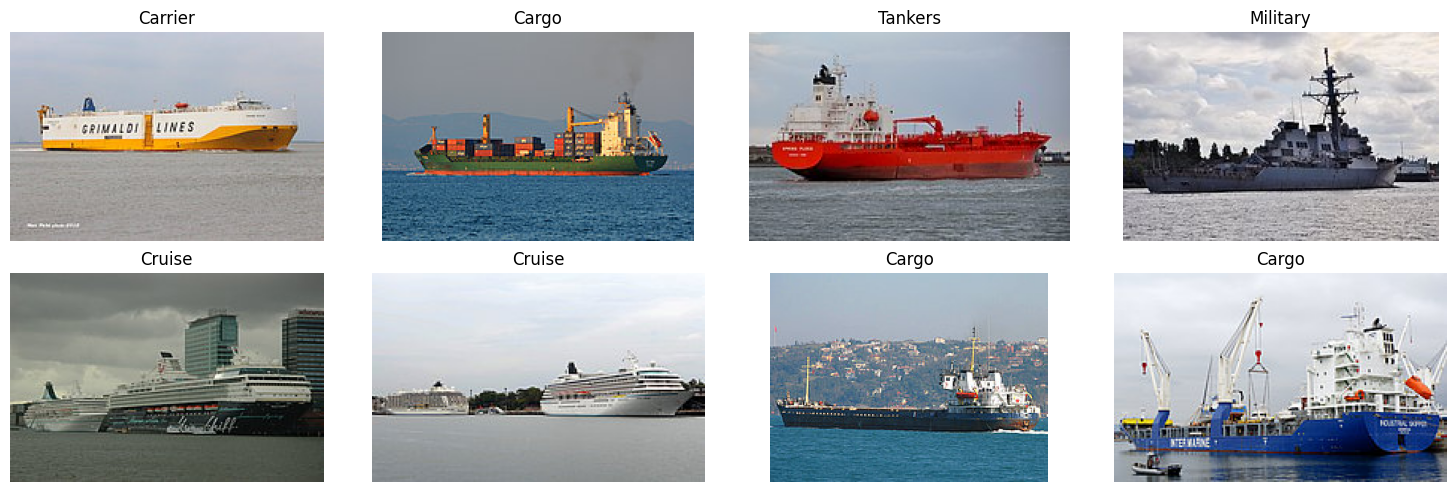

In [125]:
sample_df = train_df.sample(8).reset_index(drop=True)

plt.figure(figsize=(15, 5))

for i, row in sample_df.iterrows():
    img = Image.open(row['path'])
    label_name = ships.get(row['category'], 'Unknown')

    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(label_name)

plt.tight_layout()
plt.show()

Now we know what some of the images look like. Let's focus a little more on the characteristics of the dataset as a whole rather than specific images.

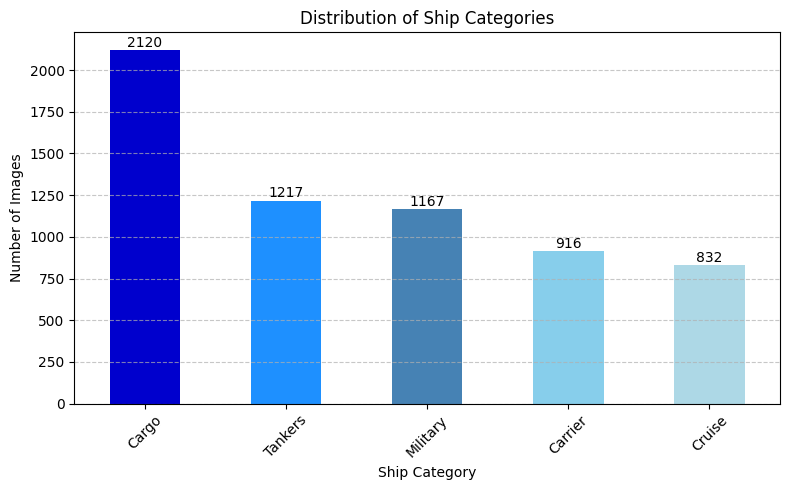

In [126]:
train_df['category_name'] = train_df['category'].map(ships)
category_counts = train_df['category_name'].value_counts().sort_values(ascending=False)

# Shades of blue to keep with our ocean theme
blue_colors = ['#0000cd', '#1e90ff', '#4682b4', '#87ceeb', '#add8e6']

plt.figure(figsize=(8, 5))
ax = category_counts.plot(kind='bar', color=blue_colors)

for i, count in enumerate(category_counts):
    ax.text(i, count + 1, str(count), ha='center', va='bottom', fontsize=10)

plt.xlabel('Ship Category')
plt.ylabel('Number of Images')
plt.title('Distribution of Ship Categories')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

So we have more cargo ships in the dataset than any other ship. We will visualize it with a pie chart below too and it doesn't look too big of a difference between classes that we need to make any adjustments at this stage.

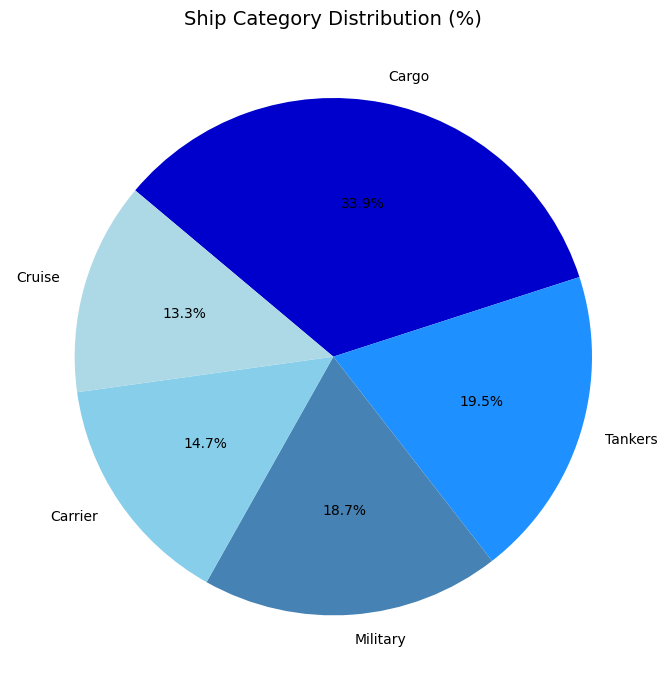

In [127]:
plt.figure(figsize=(7, 7))
plt.pie(
    category_counts,
    labels=category_counts.index,
    colors=blue_colors,
    autopct='%1.1f%%',
    startangle=140,
    counterclock=False
)

plt.title('Ship Category Distribution (%)', fontsize=14)
plt.tight_layout()
plt.show()

Now let's look at the resolutions of our images. The dataset did not give us any information about them on the site, so there is a chance they will not all be the same resolution and we will have to standardize them.

In [128]:
# get image dimensions
def get_image_size(path):
    try:
        with Image.open(path) as img:
            return img.size  # (width, height)
    except:
        return (0, 0)

train_df['img_size'] = train_df['path'].apply(get_image_size)
train_df['width'], train_df['height'] = zip(*train_df['img_size'])

In [129]:
train_df['width'].describe()

count    6252.000000
mean      209.056302
std         8.373884
min        91.000000
25%       210.000000
50%       210.000000
75%       210.000000
max       210.000000
Name: width, dtype: float64

In [130]:
train_df['height'].describe()

count    6252.000000
mean      138.979687
std        15.945287
min        41.000000
25%       137.000000
50%       140.000000
75%       149.000000
max       158.000000
Name: height, dtype: float64

It seems like we will need to resize these images to a consistent resolution so we don't get problems later on. I can't decide between 128x128 and 224x224, so I'm going to print 3 examples of each and go from there.

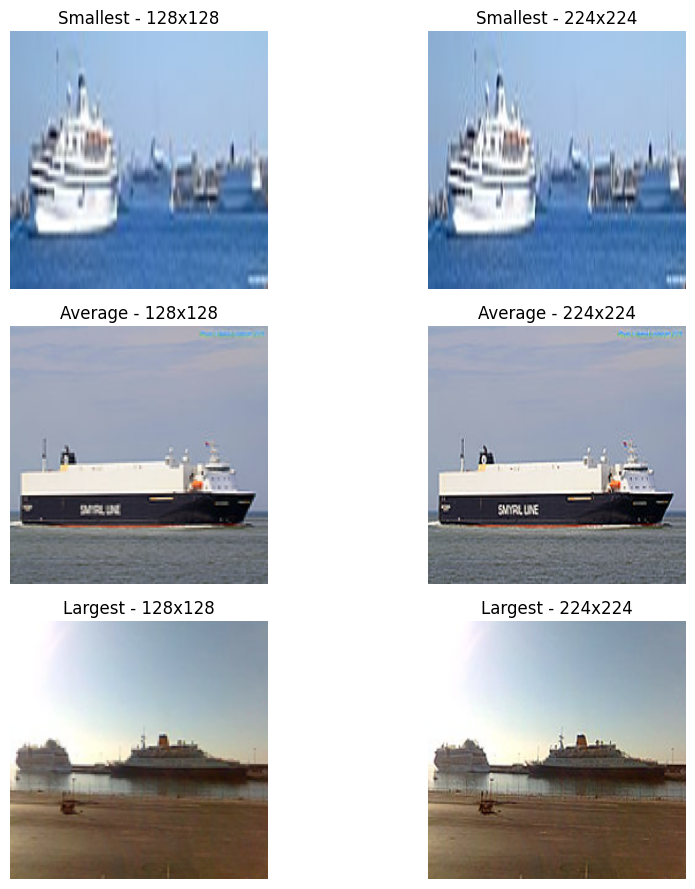

In [131]:
train_df['area'] = train_df['width'] * train_df['height']

sorted_df = train_df.sort_values(by='area').reset_index(drop=True)

smallest = sorted_df.iloc[0]
middle = sorted_df.iloc[len(sorted_df) // 2]
largest = sorted_df.iloc[-1]

examples = [smallest, middle, largest]
labels = ['Smallest', 'Average', 'Largest']
sizes = [(128, 128), (224, 224)]

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 9))

for row, (example, label) in enumerate(zip(examples, labels)):
    try:
        img = Image.open(example['path']).convert('RGB')
        for col, size in enumerate(sizes):
            resized_img = img.resize(size)
            axs[row][col].imshow(resized_img)
            axs[row][col].axis('off')
            axs[row][col].set_title(f"{label} - {size[0]}x{size[1]}")
    except Exception as e:
        print(f"Failed on {label}: {e}")

plt.tight_layout()
plt.show()

Let's take a closer look at the smallest image as it's clearly having some problems being transformed to 128x128 and 224x224.

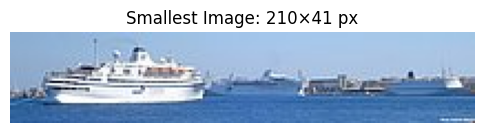

In [52]:
train_df['area'] = train_df['width'] * train_df['height']
smallest_row = train_df.sort_values('area').iloc[0]
img = Image.open(smallest_row['path'])

plt.figure(figsize=(6, 4))
plt.imshow(img)
plt.axis('off')
plt.title(f"Smallest Image: {img.size[0]}×{img.size[1]} px")
plt.show()

Let's go ahead and resize all of them to 224x224, but I am still concerned about the smallest image. The image clearly gets smushed, so I may have to add padding so we can keep the full image, and luckily our model should be able to "ignore" padding after enough training. But first let's plot the aspect ratios so we can see if this is a good tradeoff or not.

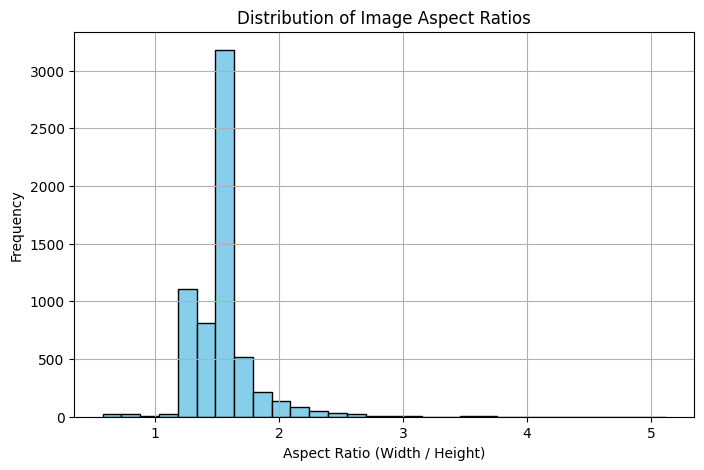

In [54]:
train_df['aspect_ratio'] = train_df['width'] / train_df['height']

plt.figure(figsize=(8, 5))
plt.hist(train_df['aspect_ratio'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Image Aspect Ratios')
plt.xlabel('Aspect Ratio (Width / Height)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

And it looks like there'll be a lot of instances where images would get smushed by being transformed to 224x224 since most images are wider than they are tall.

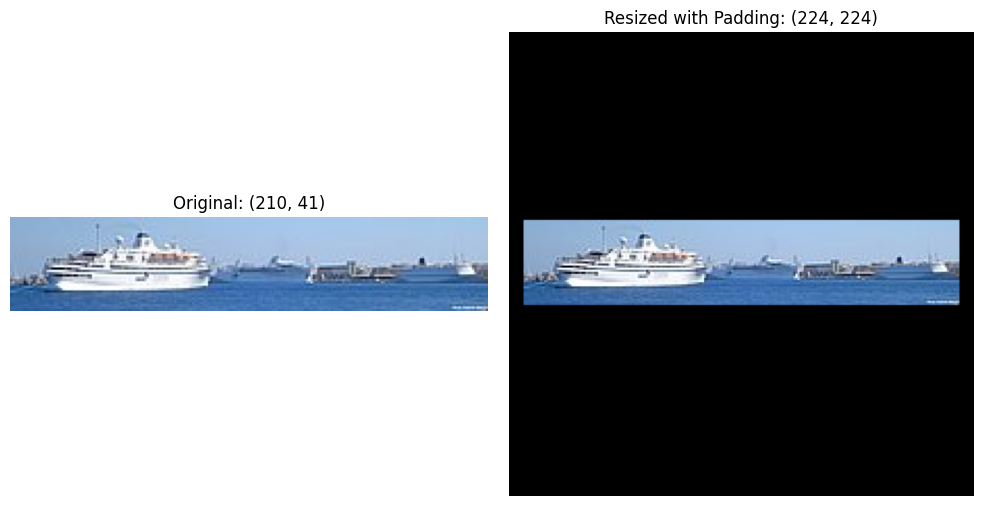

In [53]:
def resize_with_padding(img, target_size=(224, 224), fill_color=(0, 0, 0)):
    """
    Resize image while preserving aspect ratio and pad with fill_color to target_size.
    """
    img.thumbnail(target_size, Image.LANCZOS)
    delta_w = target_size[0] - img.size[0]
    delta_h = target_size[1] - img.size[1]
    padding = (delta_w // 2, delta_h // 2, delta_w - delta_w // 2, delta_h - delta_h // 2)
    return ImageOps.expand(img, padding, fill=fill_color)

smallest_row = train_df.sort_values('area').iloc[0]
img = Image.open(smallest_row['path']).convert('RGB')

resized_img = resize_with_padding(img, target_size=(224, 224))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(img)
ax1.set_title(f"Original: {img.size}")
ax1.axis('off')

ax2.imshow(resized_img)
ax2.set_title(f"Resized with Padding: {resized_img.size}")
ax2.axis('off')

plt.tight_layout()
plt.show()

This looks much better with padding although it still doesn't look great because of the relatively extreme aspect ratio. Overall, we see most images are wider than they are tall so I think when we resize it will be best to do it with the padding to make sure we don't smush all the images in our data set.

In [55]:
output_dir = 'resized_images'
os.makedirs(output_dir, exist_ok=True)

resized_count = 0

for i, row in train_df.iterrows():
    try:
        img = Image.open(row['path']).convert('RGB')
        resized_img = resize_with_padding(img, target_size=(224, 224))

        filename = os.path.basename(row['path'])
        output_path = os.path.join(output_dir, filename)
        resized_img.save(output_path)

        resized_count += 1  # Count success

    except Exception as e:
        print(f"Error processing {row['path']}: {e}")

print(f"Resized {resized_count} images")

Resized 6252 images


# Problems with this Dataset

While creating the first model I noticed the problems I'll be talking about in this section. We don't have an true labels for the test images, so there is no way we can use them to train or test the model unless I personally go through and identify all of the 2680 images. So instead, we are just going to ignore any of the images in the test set and create our own test set in the next section.

In [56]:
sample = pd.read_csv('/kaggle/input/game-of-deep-learning-ship-datasets/sample_submission_ns2btKE.csv')

In [57]:
sample['category'].describe()

count    2680.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: category, dtype: float64

In [58]:
test_df.head()

image                                               path
0  1007700.jpg  /kaggle/input/game-of-deep-learning-ship-datas...
1  1011369.jpg  /kaggle/input/game-of-deep-learning-ship-datas...
2  1051155.jpg  /kaggle/input/game-of-deep-learning-ship-datas...
3  1062001.jpg  /kaggle/input/game-of-deep-learning-ship-datas...
4  1069397.jpg  /kaggle/input/game-of-deep-learning-ship-datas...

# Creating a New Test Set

Here we will create the new test set to we can create a mock Kaggle submission and use it to test our accuracy later on.

In [59]:
train_df['filename'] = train_df['path'].apply(os.path.basename)

# Update path to point to resized images directory
train_df['path'] = train_df['filename'].apply(
    lambda x: os.path.join('/kaggle/working/resized_images', x)
)

In [60]:
# Split 150 images for a simulated test set
train_subset, test_subset = train_test_split(
    train_df,
    test_size=150,
    stratify=train_df['category'],
    random_state=42
)

print(f"Training set: {len(train_subset)} images")
print(f"Test set: {len(test_subset)} images")

Training set: 6102 images
Test set: 150 images


In [61]:
train_subset.head()

image  category                                        path  \
978   2782132.jpg         1  /kaggle/working/resized_images/2782132.jpg   
5259  2798373.jpg         1  /kaggle/working/resized_images/2798373.jpg   
5313  2837552.jpg         1  /kaggle/working/resized_images/2837552.jpg   
4497  2819073.jpg         1  /kaggle/working/resized_images/2819073.jpg   
769   2884349.jpg         1  /kaggle/working/resized_images/2884349.jpg   

     category_name    img_size  width  height   area  aspect_ratio  \
978          Cargo  (210, 138)    210     138  28980      1.521739   
5259         Cargo  (210, 157)    210     157  32970      1.337580   
5313         Cargo  (210, 115)    210     115  24150      1.826087   
4497         Cargo  (210, 140)    210     140  29400      1.500000   
769          Cargo  (210, 144)    210     144  30240      1.458333   

         filename  
978   2782132.jpg  
5259  2798373.jpg  
5313  2837552.jpg  
4497  2819073.jpg  
769   2884349.jpg

In [62]:
test_subset.head()

image  category                                        path  \
4750  2849842.jpg         1  /kaggle/working/resized_images/2849842.jpg   
1680  2802622.jpg         1  /kaggle/working/resized_images/2802622.jpg   
4091  2334114.jpg         4  /kaggle/working/resized_images/2334114.jpg   
4915  2837601.jpg         1  /kaggle/working/resized_images/2837601.jpg   
4179  2903700.jpg         2  /kaggle/working/resized_images/2903700.jpg   

     category_name    img_size  width  height   area  aspect_ratio  \
4750         Cargo  (210, 140)    210     140  29400       1.50000   
1680         Cargo  (210, 140)    210     140  29400       1.50000   
4091        Cruise  (210, 140)    210     140  29400       1.50000   
4915         Cargo  (210, 140)    210     140  29400       1.50000   
4179      Military   (210, 86)    210      86  18060       2.44186   

         filename  
4750  2849842.jpg  
1680  2802622.jpg  
4091  2334114.jpg  
4915  2837601.jpg  
4179  2903700.jpg

# Model Building

Now let's actually start creating our model. We will start with a CNN built from scratch with 4 convolutional blocks to predict which of the 5 classes each ship belongs to.

In [63]:
# Convert numeric labels (1–5) to 0–4 range
train_subset['label'] = train_subset['category'] - 1

# Image size
img_size = 224

# Load images into arrays
def load_images(df, size):
    X = []
    for path in df['path']:
        img = cv2.imread(path)
        img = cv2.resize(img, (size, size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        X.append(img)
    return np.array(X)

# Load X and y
X = load_images(train_subset, img_size)
y = train_subset['label'].values
y = to_categorical(y, num_classes=5)

# Normalize pixel values
X = X.astype('float32') / 255.0

In [64]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y.argmax(axis=1)
)

In [65]:
class ShipClassifier(tf.keras.Model):
    def __init__(self, input_size=224, num_classes=5):
        super(ShipClassifier, self).__init__()

        self.conv_block1 = models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D()
        ])

        self.conv_block2 = models.Sequential([
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D()
        ])

        self.conv_block3 = models.Sequential([
            layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D()
        ])

        self.conv_block4 = models.Sequential([
            layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D()
        ])

        self.global_pool = layers.GlobalAveragePooling2D()
        self.dense = layers.Dense(256, activation='relu')
        self.bn = layers.BatchNormalization()
        self.dropout = layers.Dropout(0.5)
        self.output_layer = layers.Dense(num_classes, activation='softmax')

    def call(self, x, training=False):
        x = self.conv_block1(x, training=training)
        x = self.conv_block2(x, training=training)
        x = self.conv_block3(x, training=training)
        x = self.conv_block4(x, training=training)
        x = self.global_pool(x)
        x = self.dense(x)
        x = self.bn(x, training=training)
        x = self.dropout(x, training=training)
        return self.output_layer(x)

Now let's compile and train our initial model.

In [66]:
with strategy.scope():
    model = ShipClassifier(input_size=img_size, num_classes=5)
    model.build(input_shape=(None, img_size, img_size, 3))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'ship_classifier_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [67]:
model_history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_val, y_val)
)

Epoch 1/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 37s 153ms/step - accuracy: 0.3130 - loss: 2.0323 - val_accuracy: 0.3391 - val_loss: 1.9688
Epoch 2/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - accuracy: 0.4987 - loss: 1.3010 - val_accuracy: 0.1884 - val_loss: 1.9767
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.5803 - loss: 1.0603 - val_accuracy: 0.3735 - val_loss: 2.2662
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - accuracy: 0.6726 - loss: 0.8619 - val_accuracy: 0.5102 - val_loss: 1.2285
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.7312 - loss: 0.7065 - val_accuracy: 0.5586 - val_loss: 1.0400
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.7761 - loss: 0.6086 - val_accuracy: 0.6568 - val_loss: 0.9887
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.8013 - loss: 0.5252 - val_accuracy: 0.6986 - val_loss: 0.8033
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.8210 - loss: 0.4652 -

In [68]:
model_history_1 = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_val, y_val)
)

Epoch 1/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 15s 96ms/step - accuracy: 0.8774 - loss: 0.3367 - val_accuracy: 0.6675 - val_loss: 1.0791
Epoch 2/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - accuracy: 0.8844 - loss: 0.3153 - val_accuracy: 0.7756 - val_loss: 0.6370
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - accuracy: 0.9124 - loss: 0.2364 - val_accuracy: 0.7969 - val_loss: 0.6214
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.9210 - loss: 0.2143 - val_accuracy: 0.5807 - val_loss: 1.5098
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - accuracy: 0.9283 - loss: 0.1999 - val_accuracy: 0.6691 - val_loss: 1.4616
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - accuracy: 0.9252 - loss: 0.2034 - val_accuracy: 0.7109 - val_loss: 1.0585
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - accuracy: 0.9552 - loss: 0.1223 - val_accuracy: 0.7985 - val_loss: 0.6048
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - accuracy: 0.9405 - loss: 0.1481 - 

In [69]:
model.summary()

Model: "ship_classifier_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)            │ (None, 112, 112, 32)        │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_7 (Sequential)            │ (None, 56, 56, 64)          │          18,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_8 (Sequential)            │ (None, 28, 28, 128)         │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_9 (Sequential)            │ (None, 14, 14, 256)         │         887,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,144,657 (12.00 MB)

 Trainable params: 1,047,557 (4.00 MB)

 Non-trainable params: 1,984 (7.75 KB)

 Optimizer params: 2,095,116 (7.99 MB)

In [70]:
# Combine history
full_history = model_history.history
for k in model_history_1.history:
    full_history[k] += model_history_1.history[k]

Above I combined the two model histories and now I'm going to print the classification report so we can see how our model is performing between classes.

In [116]:
y_pred = model.predict(X_val).argmax(axis=1)
y_true = y_val.argmax(axis=1)

print(classification_report(y_true, y_pred, target_names=list(ships.values())))

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
              precision    recall  f1-score   support

       Cargo       0.66      0.76      0.71       414
    Military       0.44      0.99      0.61       228
     Carrier       0.99      0.70      0.82       179
      Cruise       1.00      0.43      0.60       162
     Tankers       0.92      0.15      0.26       238

    accuracy                           0.63      1221
   macro avg       0.80      0.61      0.60      1221
weighted avg       0.76      0.63      0.60      1221



This model correctly classified 63% of validation samples overall, which is decent for early training but leaves room to grow.

Below I have some specific insights that we can think about as we improve the model.
- The model rarely mislabels other classes as a carrier or cruise ship seen from the high precision scores.
- We also have a high precision for tankers but low recall, meaning when it guesses tanker it's usually right but it still misses a lot tankers because it isn't guessing them frequently enough.
- The model is over-predicting military ships seen by the high recall but low precision.
- The low cruise recall tells us it's missing a lot of actual cruise ships.

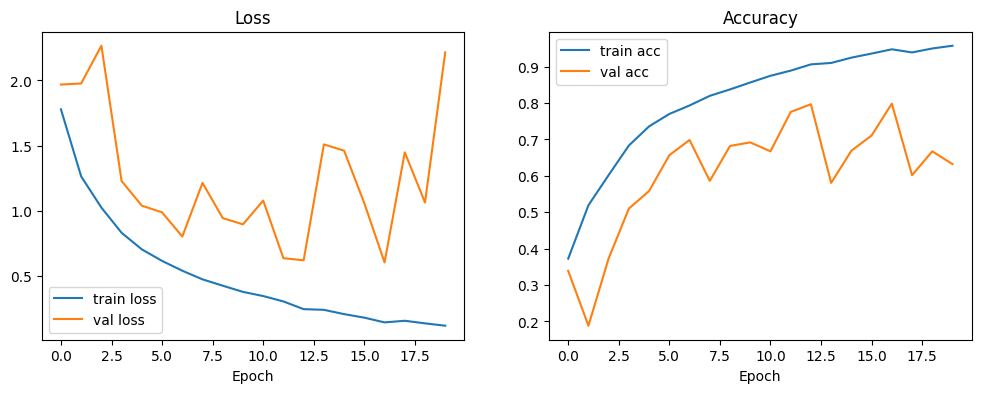

In [71]:
# Loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(model_history.history['loss'],    label='train loss')
plt.plot(model_history.history['val_loss'],label='val loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(model_history.history['accuracy'],    label='train acc')
plt.plot(model_history.history['val_accuracy'],label='val acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.legend()

plt.show()

These graphs are not bad but the divergence of validation accuracy and training accuracy tells us we may be overfitting our data a bit.

# Model Adjustments and Hyperparameter Tuning

Now let's work on improving our initial model. We will add data augmentation with the ImageDataGenerator, which will help with any concerns about overfitting. I'll also implement some callbacks so we can adjust the learning rate on fly, keep a checkpoint of the best performing instance of our model, and add earlystopping in case extra training isn't helping our validation loss.

In [72]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    fill_mode='reflect'
)

train_gen = train_datagen.flow(
    X_train,
    y_train,
    batch_size=32
)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
]

In [73]:
with strategy.scope():
    model_1 = ShipClassifier(input_size=img_size, num_classes=5)
    model_1.build(input_shape=(None, img_size, img_size, 3))
    
    model_1.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'ship_classifier_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [74]:
model_1_history = model_1.fit(
    train_gen,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


153/153 ━━━━━━━━━━━━━━━━━━━━ 70s 365ms/step - accuracy: 0.2736 - loss: 2.0942 - val_accuracy: 0.1327 - val_loss: 3.2010 - learning_rate: 0.0010
Epoch 2/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 52s 325ms/step - accuracy: 0.4253 - loss: 1.5561 - val_accuracy: 0.3284 - val_loss: 2.0276 - learning_rate: 0.0010
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 52s 326ms/step - accuracy: 0.5252 - loss: 1.2576 - val_accuracy: 0.4054 - val_loss: 1.5069 - learning_rate: 0.0010
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 52s 323ms/step - accuracy: 0.5655 - loss: 1.1057 - val_accuracy: 0.2547 - val_loss: 2.3629 - learning_rate: 0.0010
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 52s 326ms/step - accuracy: 0.6047 - loss: 1.0233 - val_accuracy: 0.4955 - val_loss: 1.6224 - learning_rate: 0.0010
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 52s 325ms/step - accuracy: 0.6512 - loss: 0.8884 - val_accuracy: 0.5913 - val_loss: 1.0906 - learning_rate: 5.0000e-04
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 52s 326ms/step - accuracy: 0.6545 - l

In [75]:
model_1_history_2 = model_1.fit(
    train_gen,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

Epoch 1/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 54s 337ms/step - accuracy: 0.7140 - loss: 0.7166 - val_accuracy: 0.6642 - val_loss: 0.8868 - learning_rate: 5.0000e-04
Epoch 2/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 52s 322ms/step - accuracy: 0.7384 - loss: 0.6624 - val_accuracy: 0.4226 - val_loss: 1.3350 - learning_rate: 5.0000e-04
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 51s 320ms/step - accuracy: 0.7320 - loss: 0.6880 - val_accuracy: 0.6847 - val_loss: 0.7886 - learning_rate: 5.0000e-04
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 51s 319ms/step - accuracy: 0.7449 - loss: 0.6405 - val_accuracy: 0.5627 - val_loss: 1.2068 - learning_rate: 5.0000e-04
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 52s 324ms/step - accuracy: 0.7667 - loss: 0.5883 - val_accuracy: 0.7289 - val_loss: 0.7281 - learning_rate: 5.0000e-04
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 51s 318ms/step - accuracy: 0.7850 - loss: 0.5629 - val_accuracy: 0.7125 - val_loss: 0.7667 - learning_rate: 5.0000e-04
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 51s 31

In [76]:
model_1_history_3 = model_1.fit(
    train_gen,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

Epoch 1/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 55s 344ms/step - accuracy: 0.8169 - loss: 0.4602 - val_accuracy: 0.7084 - val_loss: 0.8403 - learning_rate: 2.5000e-04
Epoch 2/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 52s 323ms/step - accuracy: 0.8150 - loss: 0.4695 - val_accuracy: 0.7240 - val_loss: 0.7094 - learning_rate: 2.5000e-04
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 52s 322ms/step - accuracy: 0.8364 - loss: 0.4316 - val_accuracy: 0.6396 - val_loss: 1.0992 - learning_rate: 2.5000e-04
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 52s 325ms/step - accuracy: 0.8272 - loss: 0.4358 - val_accuracy: 0.7895 - val_loss: 0.6374 - learning_rate: 2.5000e-04


Overall our model looks like it's performing a lot better and more consistently. This speaks to the power of just adding some data augmentation and callbacks. Below when looking at the model summary we'll also see the model has the same number of parameters as the original since we didn't actually change the model architecture at all.

In [132]:
model_1.summary()

Model: "ship_classifier_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_10 (Sequential)           │ (None, 112, 112, 32)        │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_11 (Sequential)           │ (None, 56, 56, 64)          │          18,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_12 (Sequential)           │ (None, 28, 28, 128)         │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_13 (Sequential)           │ (None, 14, 14, 256)         │         887,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,144,657 (12.00 MB)

 Trainable params: 1,047,557 (4.00 MB)

 Non-trainable params: 1,984 (7.75 KB)

 Optimizer params: 2,095,116 (7.99 MB)

Let's combine the model histories and just verify that we have the best one stored which should be epoch 19.

In [81]:
combined_history = {}

for key in model_1_history.history:
    combined_history[key] = model_1_history.history[key] + model_1_history_2.history.get(key, []) + model_1_history_3.history.get(key, [])

In [82]:
combined_history_obj = History()
combined_history_obj.history = combined_history

In [83]:
best_epoch = np.argmin(combined_history_obj.history['val_loss']) + 1  # +1 because epochs are 1-indexed
best_val_loss = np.min(combined_history_obj.history['val_loss'])

print(f"Best epoch was {best_epoch} with val_loss = {best_val_loss:.4f}")

Best epoch was 19 with val_loss = 0.5232


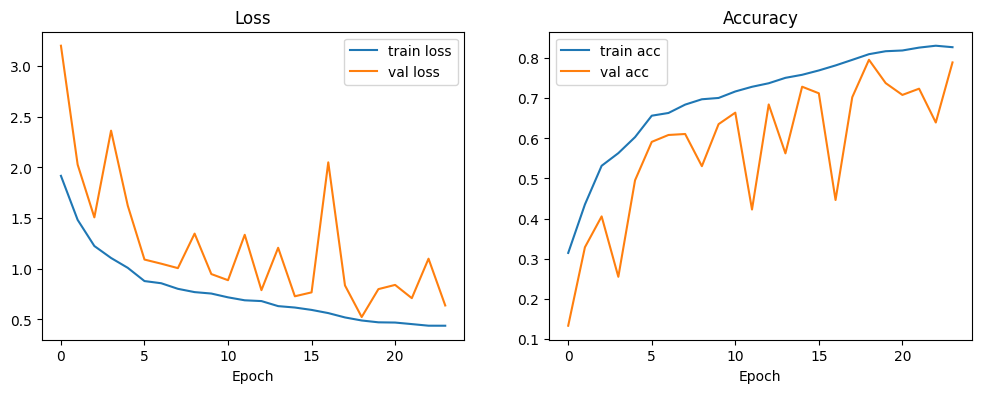

In [86]:
import matplotlib.pyplot as plt

# Loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(combined_history_obj.history['loss'],    label='train loss')
plt.plot(combined_history_obj.history['val_loss'],label='val loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(combined_history_obj.history['accuracy'],    label='train acc')
plt.plot(combined_history_obj.history['val_accuracy'],label='val acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.legend()

plt.show()

These look much better and more consistent than the original model and we also see the validation accuracy closely follows the training accuracy rather than diverging like we started to see in the original.

In [87]:
y_pred = model_1.predict(X_val).argmax(axis=1)
y_true = y_val.argmax(axis=1)

print(classification_report(y_true, y_pred, target_names=list(ships.values())))

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step
              precision    recall  f1-score   support

       Cargo       0.75      0.82      0.78       414
    Military       0.71      0.92      0.80       228
     Carrier       0.99      0.69      0.82       179
      Cruise       0.87      0.81      0.84       162
     Tankers       0.79      0.63      0.70       238

    accuracy                           0.78      1221
   macro avg       0.82      0.78      0.79      1221
weighted avg       0.80      0.78      0.78      1221



This classification report also looks much better and here are some more insights on how we can read this:
- It's likely overguessing military since the precision is only .71 but the recall is very high.
- When it guesses carrier it's almost always right but it probably doesn't guess it enough.
- Tanks definitely looks like the weakest category with .79 and .63 as the precision and recall respectively.

Since it looks like the model is struggling the most with military and tanker, let's just print a couple sample image and both and see if we can understand why that is.

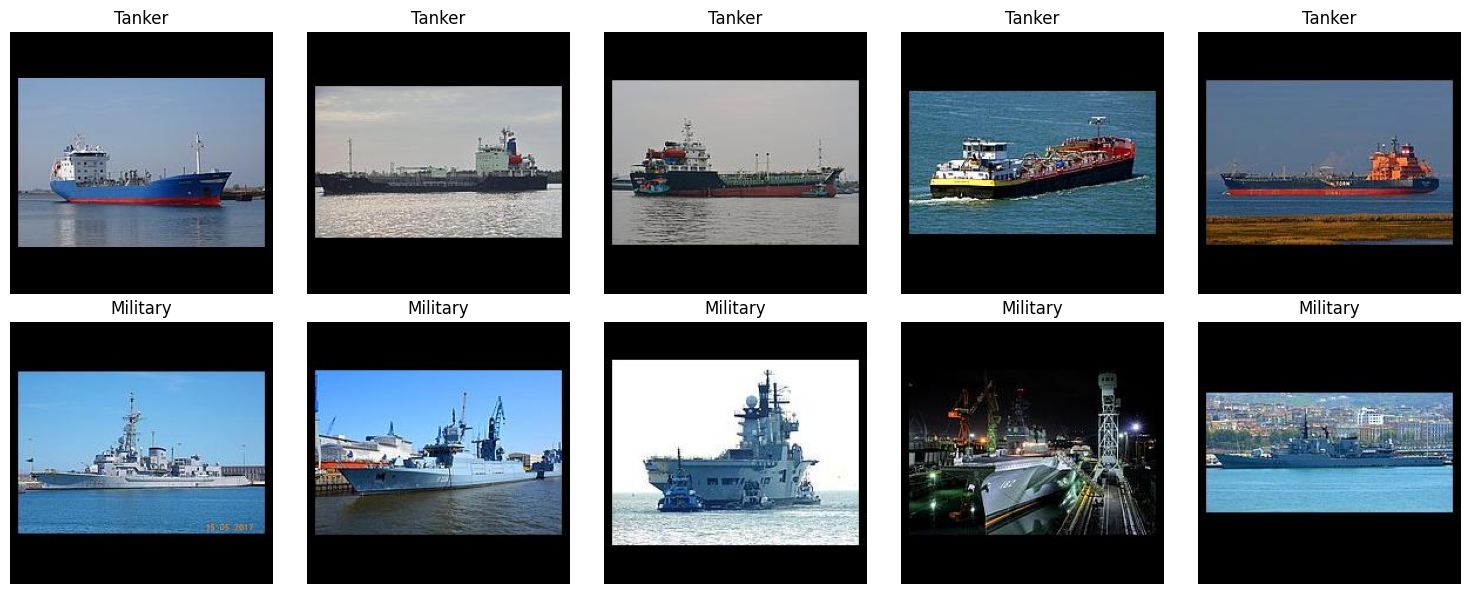

In [118]:
tankers_df = train_df[train_df['category'] == 5]
military_df = train_df[train_df['category'] == 2]

sample_tankers = tankers_df.sample(5, random_state=42)
sample_military = military_df.sample(5, random_state=42)


plt.figure(figsize=(15, 6))  # Taller figure to fit 2 rows

# Plot Tankers
for i, (_, row) in enumerate(sample_tankers.iterrows()):
    img = Image.open(row['path'])
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title("Tanker")
    plt.axis('off')

# Plot Military
for i, (_, row) in enumerate(sample_military.iterrows()):
    img = Image.open(row['path'])
    plt.subplot(2, 5, 5 + i + 1)
    plt.imshow(img)
    plt.title("Military")
    plt.axis('off')

plt.tight_layout()
plt.show()

Now let's show some of the "worst losses" the model has which is basically when the model was very confident but still got it wrong.

In [109]:
y_true = y_val.argmax(axis=1)
y_probs = model_1.predict(X_val)
y_pred = y_probs.argmax(axis=1)

# Max confidence per prediction
confidences = y_probs.max(axis=1)

# Find wrong predictions
wrong_mask = y_pred != y_true

# Build a DataFrame for easy sorting
misses_df = pd.DataFrame({
    'true_label': y_true,
    'pred_label': y_pred,
    'confidence': confidences,
    'index': np.arange(len(y_true))
})

# Filter only incorrect predictions
worst_misses = misses_df[wrong_mask].sort_values(by='confidence', ascending=False)

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


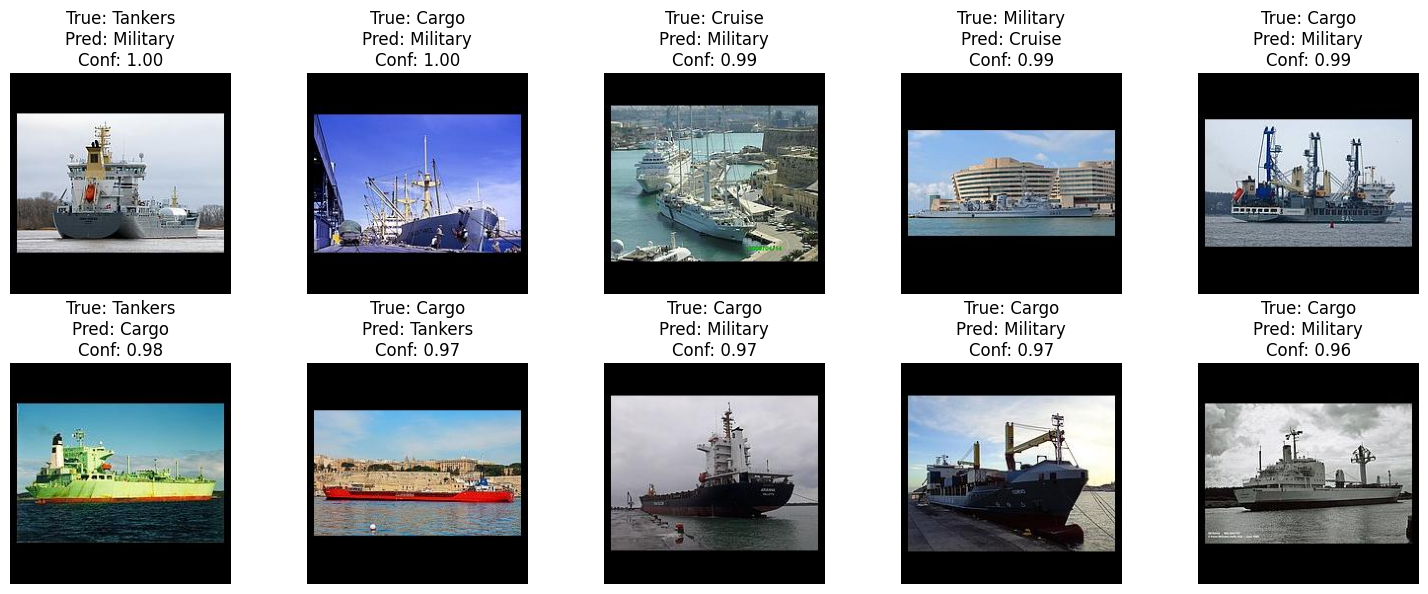

In [113]:
plt.figure(figsize=(15, 6))
n = 10

for plot_idx, row in enumerate(worst_misses.head(n).itertuples()):
    idx = row.index  # Index into X_val
    
    true_label_name = ships[y_true[idx] + 1]
    pred_label_name = ships[y_pred[idx] + 1]

    plt.subplot(2, 5, plot_idx + 1)
    plt.imshow(X_val[idx])
    plt.title(f"True: {true_label_name}\nPred: {pred_label_name}\nConf: {row.confidence:.2f}")
    plt.axis('off')

plt.tight_layout()
plt.show()

And after looking at these misses, I think this indicates that our model is actually performing very well and that it may not have a lot more room to improve with this dataset. We can see some of these images are confusing, and I'm not a ship expert but I would have gotten some of these wrong as well so this looks pretty good to me. You can also see how it is determining what kind of ship each one is. Whenever a ship looks like it has something on the middle of it that could be confused for a mast, it looks like the model is predicting those as military ships. It's not good that our model is getting confused, but it is good our model is clearly learning things baout each kind of ship.

Now let's look at the distribution of the misses to see if one category has a larger or smaller quantity of misses than other categories.

In [111]:
wrong_mask = y_true != y_pred
wrong_true_labels = y_true[wrong_mask]
wrong_pred_labels = y_pred[wrong_mask]

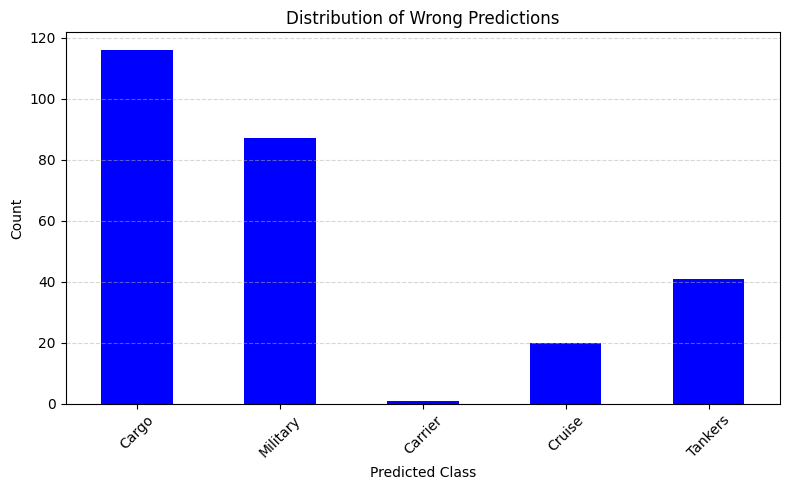

In [112]:
# Count each wrong prediction
wrong_preds = pd.Series(wrong_pred_labels).value_counts().sort_index()

# Map back to class names
ships = {
    1: 'Cargo',
    2: 'Military',
    3: 'Carrier',
    4: 'Cruise',
    5: 'Tankers'
}
wrong_preds.index = [ships[i + 1] for i in wrong_preds.index]  # Adjust for 1-based mapping

# Plot bar chart
plt.figure(figsize=(8, 5))
wrong_preds.plot(kind='bar', color='blue')
plt.title("Distribution of Wrong Predictions")
plt.ylabel("Count")
plt.xlabel("Predicted Class")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

And with this chart we see most of the misses by our model by quantity where when it predicted ships to be either cargo or military ships.

# Mock Submission

Now let's use that test set we created earlier to make sample submissions. I'll create one for the original model and the new and improved run and see how they compare.

In [96]:
test_subset.head()

image  category                                        path  \
4750  2849842.jpg         1  /kaggle/working/resized_images/2849842.jpg   
1680  2802622.jpg         1  /kaggle/working/resized_images/2802622.jpg   
4091  2334114.jpg         4  /kaggle/working/resized_images/2334114.jpg   
4915  2837601.jpg         1  /kaggle/working/resized_images/2837601.jpg   
4179  2903700.jpg         2  /kaggle/working/resized_images/2903700.jpg   

     category_name    img_size  width  height   area  aspect_ratio  \
4750         Cargo  (210, 140)    210     140  29400       1.50000   
1680         Cargo  (210, 140)    210     140  29400       1.50000   
4091        Cruise  (210, 140)    210     140  29400       1.50000   
4915         Cargo  (210, 140)    210     140  29400       1.50000   
4179      Military   (210, 86)    210      86  18060       2.44186   

         filename  
4750  2849842.jpg  
1680  2802622.jpg  
4091  2334114.jpg  
4915  2837601.jpg  
4179  2903700.jpg

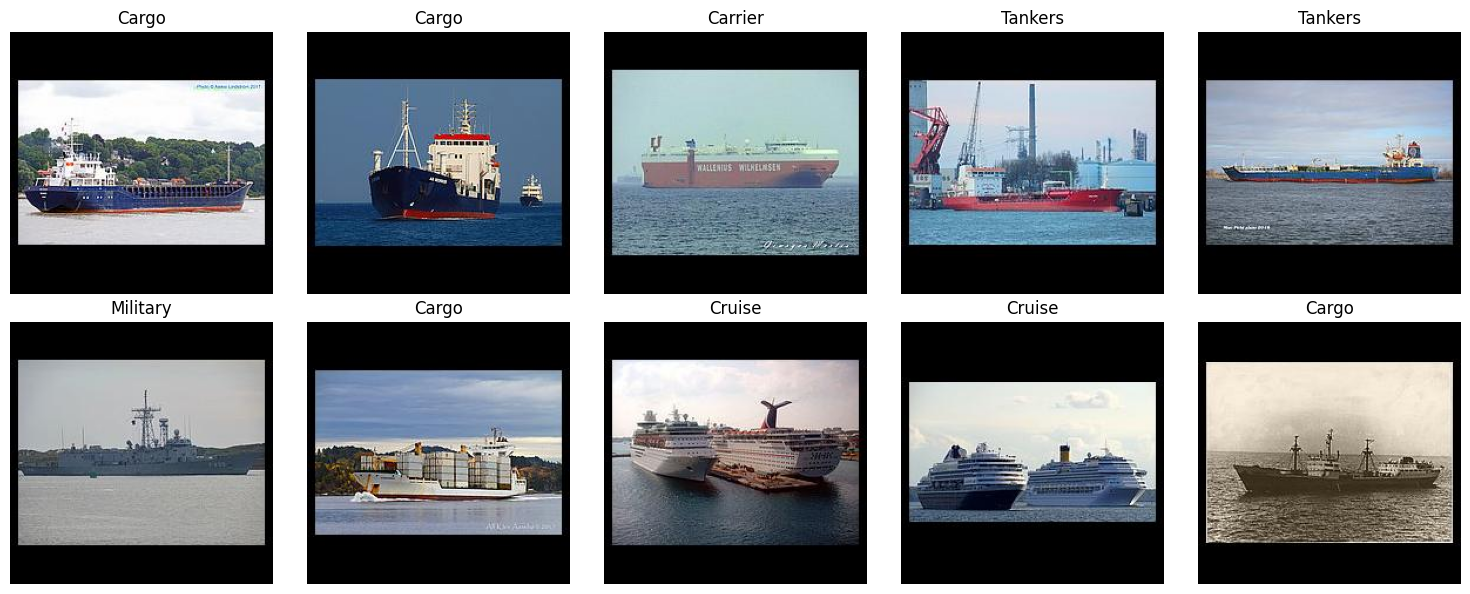

In [98]:
# Sample N random rows from test_subset
sample_test = test_subset.sample(10, random_state=42)  # change N as needed

plt.figure(figsize=(15, 6))
for i, (_, row) in enumerate(sample_test.iterrows()):
    img = Image.open(row['path'])
    
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(row['category_name'])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [99]:
test_subset = test_subset[['image', 'category', 'path']]
test_subset.head()

image  category                                        path
4750  2849842.jpg         1  /kaggle/working/resized_images/2849842.jpg
1680  2802622.jpg         1  /kaggle/working/resized_images/2802622.jpg
4091  2334114.jpg         4  /kaggle/working/resized_images/2334114.jpg
4915  2837601.jpg         1  /kaggle/working/resized_images/2837601.jpg
4179  2903700.jpg         2  /kaggle/working/resized_images/2903700.jpg

In [100]:
img_size = 224

X_test = []
for path in test_subset['path']:
    img = Image.open(path).convert('RGB')
    X_test.append(np.array(img))

X_test = np.array(X_test).astype('float32') / 255.0

## First Model Results

In [114]:
# Predict
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1) + 1  # shift 0–4 → 1–5

y_true = test_subset['category'].values
acc = accuracy_score(y_true, y_pred)

print(f"Test Accuracy: {acc * 100:.2f}%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Test Accuracy: 68.00%


## Second Model Results

In [115]:
# Predict
y_pred_probs = model_1.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1) + 1

y_true = test_subset['category'].values
acc = accuracy_score(y_true, y_pred)

print(f"Test Accuracy: {acc * 100:.2f}%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Test Accuracy: 75.33%


# Conclusion

Overall, both models did pretty well but the 2nd model I think had a really good performance and accuracy overall. It's performance was replicable and easily translated onto the test set with a consistent and pretty high accuracy. We should keep in mind too that this is not a binary clssification problem where a model could just guess and get 50% accuracy, instead we have 5 categories here and randomly guessing would get us closer to 20% accuracy. 

This tells us our model clearly learned from the dataset and if we were to improve it even further, I think we could try transfer learning but also getting a larger and cleaner dataset. If this were to be used in the real world, there would probably be multiple angles of the same ship we can capture so really, I think this is probably performing even stronger than we would think based on the accuracy and could easily be translated to a real-world scenrio.